<a href="https://colab.research.google.com/github/braginkit/neural-networks-with-Python/blob/main/IBM_stock_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

In [ ]:
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Реальные цены на акции IBM')
    plt.plot(predicted, color='blue',label='Предсказанные цены на акции IBM')
    plt.title('Предсказание цен на акции IBM')
    plt.xlabel('Время')
    plt.ylabel('Цена за акцию')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("Среднеквадратичная ошибка: {}.".format(rmse))

Импорт данных

In [ ]:
dataset = pd.read_csv('IBM_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])
dataset.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM


In [ ]:
# проверка на пропуски в данных
training_set = dataset[:'2016'].iloc[:,1:2].values
test_set = dataset['2017':].iloc[:,1:2].values

Посмотрим на то, как изменялась "высокая" цена за акцию с течением времени

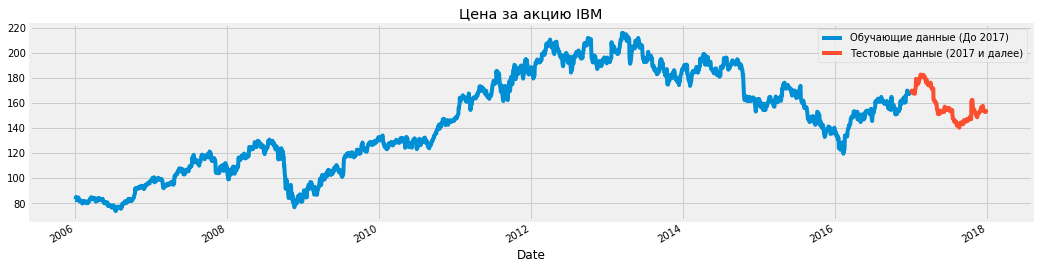

In [ ]:
dataset["High"][:'2016'].plot(figsize=(16,4),legend=True)
dataset["High"]['2017':].plot(figsize=(16,4),legend=True)
plt.legend(['Обучающие данные (До 2017)','Тестовые данные (2017 и далее)'])
plt.title('Цена за акцию IBM')
plt.show()

In [ ]:
# поменяем масштаб
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

Поскольку LSTM долгое время хранит состония памяти, создадим структуру данных из 60 предыдущих состояний и 1 вывода. Получается, что для каждого элемента тренировочных данных у нас есть 60 предыдущих состояний в памяти

In [ ]:
X_train = []
y_train = []
for i in range(60,2769):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

Описание архитектуры LSTM

In [ ]:
regressor = Sequential()
# Первый LSTM-нейрон
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Второй LSTM-нейрон
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Третий LSTM-нейрон
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Четвертый LSTM-нейрон
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# Последний нерон, делающий финальный вывод
regressor.add(Dense(units=1))

# Компилирование
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
# Обучение модели
regressor.fit(X_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
85/85 [==============================] - 33s 117ms/step - loss: 0.0472
Epoch 2/50
85/85 [==============================] - 10s 118ms/step - loss: 0.0094
Epoch 3/50
85/85 [==============================] - 10s 118ms/step - loss: 0.0084
Epoch 4/50
85/85 [==============================] - 10s 118ms/step - loss: 0.0072
Epoch 5/50
85/85 [==============================] - 10s 119ms/step - loss: 0.0075
Epoch 6/50
85/85 [==============================] - 10s 118ms/step - loss: 0.0051
Epoch 7/50
85/85 [==============================] - 10s 120ms/step - loss: 0.0051
Epoch 8/50
85/85 [==============================] - 10s 118ms/step - loss: 0.0042
Epoch 9/50
85/85 [==============================] - 10s 118ms/step - loss: 0.0039
Epoch 10/50
85/85 [==============================] - 10s 117ms/step - loss: 0.0042
Epoch 11/50
85/85 [==============================] - 10s 117ms/step - loss: 0.0040
Epoch 12/50
85/85 [==============================] - 10s 118ms/step - loss: 0.0035
Epoch 13/50
8

In [ ]:
dataset_total = pd.concat((dataset["High"][:'2016'],dataset["High"]['2017':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

Запускаем модель для предсказывания цен

In [ ]:
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

Визуализация результатов работы LSTM

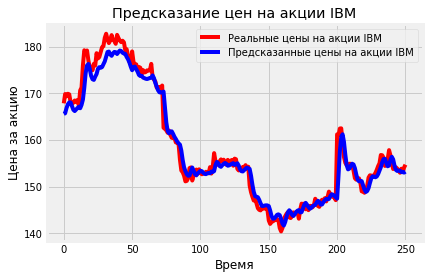

In [ ]:
plot_predictions(test_set,predicted_stock_price)

Оценка полученного результата

In [ ]:
return_rmse(test_set,predicted_stock_price)

Среднеквадратичная ошибка: 2.209262248031754.


Решим эту же задачу еще раз с использованием  механизма управляемого рекуррентного блока (GRU)

In [ ]:
# Архитектура GRU
regressorGRU = Sequential()
# Первый GRU-нейрон
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Второй GRU-нейрон
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Третий GRU-нейрон
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Четвертый GRU-нейрон
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Нейроон, выдающий финальный результат
regressorGRU.add(Dense(units=1))
# Компилирование
regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Обучение модели
regressorGRU.fit(X_train,y_train,epochs=50,batch_size=150)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/50
19/19 [==============================] - 13s 222ms/step - loss: 0.1558
Epoch 2/50
19/19 [==============================] - 4s 224ms/step - loss: 0.0400
Epoch 3/50
19/19 [==============================] - 4s 223ms/step - loss: 0.0114
Epoch 4/50
19/19 [==============================] - 4s 219ms/step - loss: 0.0051
Epoch 5/50
19/19 [==============================] - 4s 217ms/step - loss: 0.0046
Epoch 6/50
19/19 [==============================] - 4s 222ms/step - loss: 0.0039
Epoch 7/50
19/19 [==============================] - 4s 222ms/step - loss: 0.0038
Epoch 8/50
19/19 [==============================] - 4s 221ms/step - loss: 0.0034
Epoch 9/50
19/19 [==============================] - 4s 220ms/step - loss: 0.0033
Epoch 10/50
19/19 [==============================] - 4s 220ms/step - loss: 0.0032
Epoch 11/50
19/19 [==============================] - 4s 220ms/step - loss: 0.0033
Epoch 12/50
19/19 [==============================] - 4s 222ms/step - loss: 0.0032
Epoch 13/50
19/19 [=====

In [ ]:
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

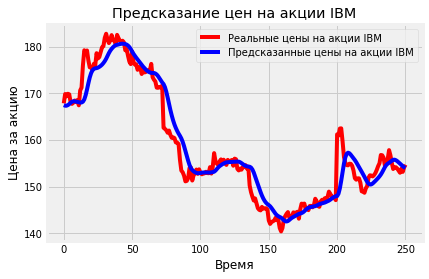

In [ ]:
plot_predictions(test_set,GRU_predicted_stock_price)

In [ ]:
return_rmse(test_set,GRU_predicted_stock_price)

Среднеквадратичная ошибка: 3.2037948373867344.
